# Face Recognition

Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf).

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, the [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, it can then determine if two pictures are of the same person.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Naive Face Verification

In Face Verification, we're given two images and we have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same person! Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

Instead, rather than using the raw image, we can learn an encoding, $f(img)$. By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

## Encoding Face Images into a 128-Dimensional Vector

### Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, we'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) An Inception network implementation is in the file `inception_blocks_v2.py`.

- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, we need to scale them to 160x160.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. We then use the encodings to compare two face images as follows:

<img src="images/distance_kiank.png" style="width:680px;">
<caption><center> <u> <font color='purple'> <b>Figure 2:</b> <br> </font> </u> <font color='purple'>By computing the distance between two encodings and thresholding, we can determine if the two pictures represent the same person</font></center></caption>

So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.
    
<img src="images/triplet_comparison.png" style="width:280px;"><br>
<caption><center> <u> <font color='purple'> <b>Figure 3: </b> <br> </font></u> <font color='purple'> In the next section,  we'll call the pictures from left to right: Anchor (A), Positive (P), Negative (N)</font></center></caption>

In [12]:
class FaceRecognitionModel(nn.Module):
    def __init__(self, embedding_size=128):
        super(FaceRecognitionModel, self).__init__()

        # Load a pre-trained Inception model
        self.inception = models.inception_v3(pretrained=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embedding_size)
    
    def forward(self, images):
        embeddings = self.inception(images)
        embeddings = nn.functional.normalize(embeddings)
        return embeddings
    
model = FaceRecognitionModel()
model.to(device)

FaceRecognitionModel(
  (inception): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4

### The Triplet Loss

**Note**: Since we're using a pretrained model, we won't actually need to implement the triplet loss function. *However*, the triplet loss is the main ingredient of the face recognition algorithm. Therefore, we'll implement it below, for fun and edification. :) 

For an image $x$, its encoding is denoted as $f(x)$, where $f$ is the function computed by the neural network.

<img src="images/f_x.png" style="width:380px;">

Training will use triplets of images $(A, P, N)$:

- A is an "Anchor" image -- a picture of a person.
- P is a "Positive" image -- a picture of the same person as the Anchor image.
- N is a "Negative" image -- a picture of a different person than the Anchor image.

These triplets are picked from the training dataset. $(A^{(i)}, P^{(i)}, N^{(i)})$ is used here to denote the $i$-th training example.

We'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$
|| f\left(A^{(i)}\right)-f\left(P^{(i)}\right)||_{2}^{2}+\alpha<|| f\left(A^{(i)}\right)-f\left(N^{(i)}\right)||_{2}^{2}
$$


We would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$
Here, the notation "$[z]_+$" is used to denote $max(z,0)$.

**Notes**:

- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; we want this to be small.
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, we want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It's a hyperparameter that we pick manually. We'll use $\alpha = 0.2$.

In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

## Applying the Model

We're building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.

We'd like to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.

### Face Verification

Now we'll build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding, we'll use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.

In [13]:
def img_to_encoding(image_path, model, device='cuda'):
    # Load and resize the image using PIL
    img = Image.open(image_path)
    img = img.resize((160, 160))

    # Convert RGBA to RGB if necessary
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Define the image transformation
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert the PIL Image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Apply the transformation to the image
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Move tensor to the appropriate device
    img_tensor = img_tensor.to(device)

    # Forward pass through the model to get the embedding
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        embedding = model(img_tensor)

    # Normalize the embedding
    embedding = embedding / torch.norm(embedding, p=2, dim=1)

    return embedding.cpu().numpy()

In [14]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", model)
database["younes"] = img_to_encoding("images/younes.jpg", model)
database["tian"] = img_to_encoding("images/tian.jpg", model)
database["andrew"] = img_to_encoding("images/andrew.jpg", model)
database["kian"] = img_to_encoding("images/kian.jpg", model)
database["dan"] = img_to_encoding("images/dan.jpg", model)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", model)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", model)
database["kevin"] = img_to_encoding("images/kevin.jpg", model)
database["felix"] = img_to_encoding("images/felix.jpg", model)
database["benoit"] = img_to_encoding("images/benoit.jpg", model)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", model)

Now, when someone shows up at the front door and swipes their ID card (thus giving us their name), we can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

In [23]:
def verify(image_path, identity, database, model, device):
    """Verifies if the person on the "image_path" image is "identity".

    Arguments:
        image_path -- path to an image
        identity -- string, name of the person to verify the identity against
        database -- dictionary mapping names to their encodings (as NumPy arrays)
        model -- your face recognition model
        device -- the device (CPU or GPU) to perform computations on

    Returns:
        dist -- distance between the image_path and the image of "identity" in the database
        door_open -- True, if the door should open. False otherwise
    """
    
    # Convert the image to encoding
    encoding = img_to_encoding(image_path, model, device)

    # Compute the distance
    dist = np.linalg.norm(encoding - database[identity])

    # Open the door if dist < 0.7, else don't open
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    
    return dist, door_open

In [24]:
# younes is in the database, the model should recognize younes

distance, door_open_flag = verify("images/camera_0.jpg", "younes", database, model, device)
print("(", distance, ",", door_open_flag, ")")

It's younes, welcome in!
( 0.6139134 , True )


In [26]:
# Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. 
# The camera took a picture of Benoit ("images/camera_2.jpg). 

verify("images/camera_2.jpg", "kian", database, model, device)

It's not kian, please go away


(1.0166304, False)

### Face Recognition

The face verification system is mostly working. But since Kian got his ID card stolen, when he came back to the office the next day he couldn't get in!

To solve this, we'd like to change our face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them!

We'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, we will no longer get a person's name as one of the inputs.

In [27]:
def who_is_it(image_path, database, model, device='cuda'):
    """Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    # Compute the target "encoding" for the image
    encoding = img_to_encoding(image_path, model, device)

    # Initialize "min_dist" to a large value
    min_dist = 100
    identity = None

    # Loop over the database
    for (name, db_enc) in database.items():
        # Compute L2 distance between the target "encoding" and the current "db_enc" from the database
        dist = np.linalg.norm(encoding - db_enc)

        # Update min_dist and identity if needed
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print("It's " + str(identity) + ", the distance is " + str(min_dist))
    
    return min_dist, identity

Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if `who_it_is()` algorithm identifies Younes.

In [30]:
who_is_it("images/camera_0.jpg", database, model)
who_is_it("images/camera_1.jpg", database, model)
who_is_it("images/younes.jpg", database, model)

It's younes, the distance is 0.6139134
It's bertrand, the distance is 0.5837223
It's younes, the distance is 0.0


(0.0, 'younes')

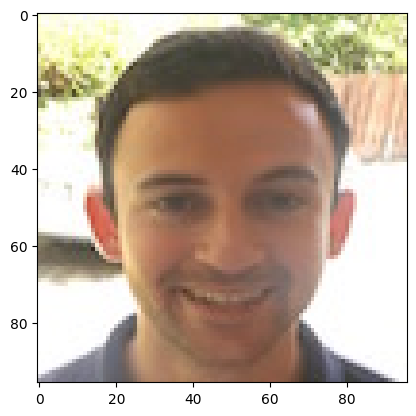

In [31]:
plt.imshow(Image.open("images/camera_0.jpg"))

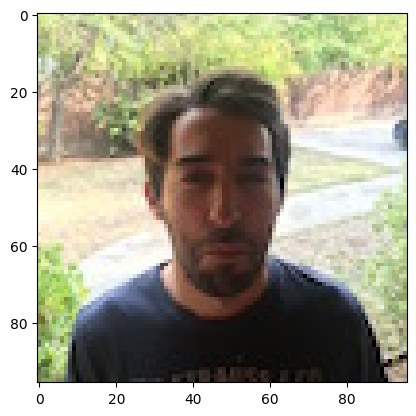

In [32]:
plt.imshow(Image.open("images/camera_1.jpg"))

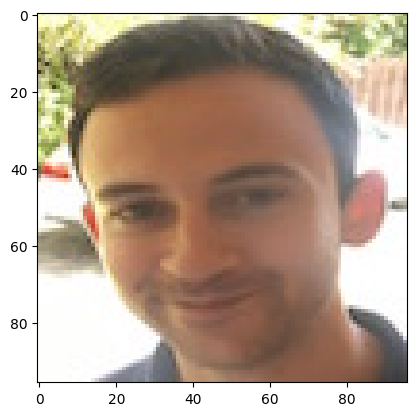

In [33]:
plt.imshow(Image.open("images/younes.jpg"))